# MaxViT Tutotial

**Note**: Please connect to a GPU runtime instance. Make sure tensorflow can be imported.


<table align="left"><td>
  <a target="_blank"  href="https://github.com/google-research/maxvit/MaxViT_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on github
  </a>
</td><td>
  <a target="_blank"  href="https://colab.research.google.com/github/google-research/maxvit/blob/master/MaxViT_tutorial.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
</td></table>

## 0. Import libraries

In [ ]:
#@title Import libs
import time
from IPython import display
import tensorflow as tf
import tensorflow.compat.v1 as tf1
import tensorflow_datasets as tfds
!git clone https://github.com/google-research/maxvit
%cd /content/maxvit
# set up module
!python setup.py install

# imports
import maxvit.models.hparams as hparams
import maxvit.models.maxvit as layers

# Checkpoints location
CKPTS_DIRS = {
    'MaxViTTiny_i1k_224': 'gs://gresearch/maxvit/ckpts/maxvittiny/i1k/224',
    'MaxViTTiny_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvittiny/i1k/384',
    'MaxViTTiny_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvittiny/i1k/512',
    'MaxViTSmall_i1k_224': 'gs://gresearch/maxvit/ckpts/maxvitsmall/i1k/224',
    'MaxViTSmall_i1k_384': 'gs://gresearch/maxvit/ckpts/maxvitsmall/i1k/384',
    'MaxViTSmall_i1k_512': 'gs://gresearch/maxvit/ckpts/maxvitsmall/i1k/512',
    'MaxViTBase_i1k_224': '',
    'MaxViTBase_i1k_384': '',
    'MaxViTBase_i1k_512': '',
    'MaxViTLarge_i1k_224': '',
    'MaxViTLarge_i1k_384': '',
    'MaxViTLarge_i1k_512': '',
    'MaxViTXLarge_i1k_224': '',
    'MaxViTXLarge_i1k_384': '',
    'MaxViTXLarge_i1k_512': '',
}
DATASET_MAP = {
    'ImageNet-1K': 'i1k', 
    'ImageNet-21K': 'i21k_i1k',
}

## 1. Benchmark inference time

In [29]:
#@title Set model and params

MODEL_NAME = "MaxViTTiny" #@param ["MaxViTTiny", "MaxViTSmall", "MaxViTBase", "MaxViTLarge"] {type:"string"}
IMAGE_SIZE = "224" #@param [224, 384, 512] {type:"string"}
BATCH_SIZE = 16 #@param {type:"integer"}
MIXED_PRECISION = True #@param {type:"boolean"}

IMAGE_SIZE = int(IMAGE_SIZE)


class MaxViTModel(tf.keras.Model):
  """class to build MaxViT family model."""
  def __init__(self,
               model_name='',
               model_input_size=224,
               input_specs=tf.keras.layers.InputSpec(
                   shape=[None, None, None, 3]),
               training=True):
    """VisionTransformer initialization function."""
    inputs = tf.keras.Input(shape=input_specs.shape[1:])
    config = hparams.lookup(model_name)

    if model_input_size == 224:
      config.model.window_size = 7
      config.model.grid_size = 7
      config.model.scale_ratio = None
    elif model_input_size == 384:
      config.model.window_size = 12
      config.model.grid_size = 12
      config.model.scale_ratio = '384/224'
    elif model_input_size == 512:
      config.model.window_size = 16
      config.model.grid_size = 16
      config.model.scale_ratio = '512/224'

    model = layers.MaxViT(config.model)
    out = model(inputs, training=training)

    super(MaxViTModel, self).__init__(inputs=inputs, outputs=out)


def build_tf2_model():
  """Build the tf2 model."""
  if MIXED_PRECISION:
    # Use 'mixed_float16' if running on GPUs.
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
  model = MaxViTModel(model_name=MODEL_NAME,
                      model_input_size=IMAGE_SIZE,
                      input_specs=tf.keras.layers.InputSpec(
                      shape=[BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3]),
                      training=False)
  return model


def run_tf_benchmark():
  """Run benchmark."""
  model = build_tf2_model()
  imgs = tf.ones((BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=tf.float16)

  @tf.function
  def f(x):
    return model(x, training=False)

  print('starting warmup.')
  for _ in range(10):  # warmup runs.
    f(imgs)

  print('start benchmark.')
  start = time.perf_counter()
  for _ in range(10):
    f(imgs)
  end = time.perf_counter()
  inference_time = (end - start) / 10

  print('Per batch inference time: ', inference_time)
  print('FPS: ', BATCH_SIZE / inference_time)

run_tf_benchmark()

starting warmup.
start benchmark.
Per batch inference time:  0.1288079572999777
FPS:  124.2159283897189


## 2. Inference on images

In [30]:
#@title Set model and params

MODEL_NAME = "MaxViTTiny" #@param ["MaxViTTiny", "MaxViTSmall"] {type:"string"}
TRAIN_SET = "ImageNet-1K" #@param ["ImageNet-1K"] {type:"string"}
TRAIN_IMAGE_SIZE = "224" #@param [224, 384, 512] {type:"string"}
MIXED_PRECISION = False #@param {type:"boolean"}

CKPT_DIR = CKPTS_DIRS[f'{MODEL_NAME}_{DATASET_MAP[TRAIN_SET]}_{TRAIN_IMAGE_SIZE}']

--2022-10-04 07:54:42--  https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>] 113.35K  --.-KB/s    in 0.05s   

2022-10-04 07:54:42 (2.42 MB/s) - ‘panda.jpg’ saved [116068/116068]

Input image:


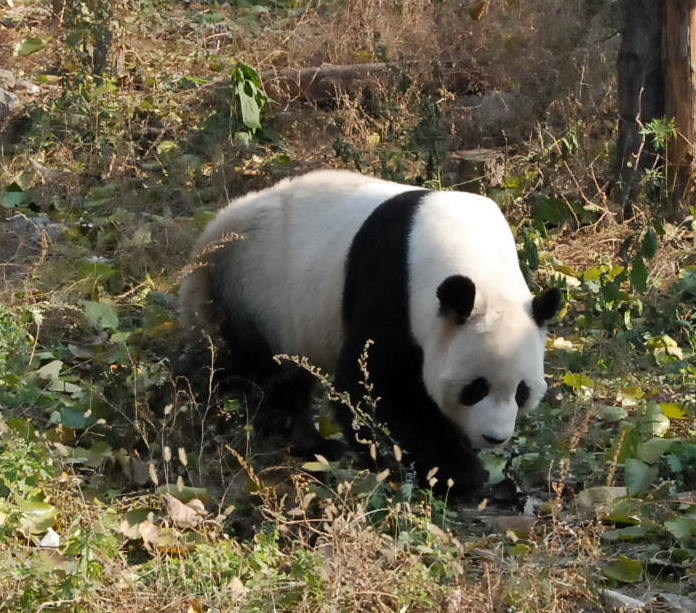

MaxViT prediction:
predicted class for image panda.jpg: 
  -> top_0 (87.55%): giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca  
  -> top_1 (0.12%): lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens  
  -> top_2 (0.06%): soccer ball  
  -> top_3 (0.05%): earthstar  
  -> top_4 (0.03%): chickadee  


In [31]:
#@title Inference on example image
import maxvit.models.eval_ckpt as eval_ckpt

#@markdown ### Enter a file path:
file_path = "https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG" #@param {type:"string"}
INFER_IMAGE_SIZE = "224" #@param [224, 384, 448, 512, 672, 768, 896, 1024] {type:"string"}

# Download label map file and image
labels_map_file = 'gs://cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.json'
image_file = 'panda.jpg'

!wget {file_path} -O {image_file}

image_files = [image_file]

eval_driver = eval_ckpt.MaxViTDriver(
    model_name=MODEL_NAME,
    model_input_size=TRAIN_IMAGE_SIZE,
    batch_size=1,
    image_size=int(INFER_IMAGE_SIZE),
    include_background_label=False,
    advprop_preprocessing=False,)

print(f"Input image:")
display.display(display.Image(image_file, width=INFER_IMAGE_SIZE))

print(f"MaxViT prediction:")
pred_idx, pred_prob = eval_driver.eval_example_images(
    CKPT_DIR, image_files, labels_map_file)

## 3. Directly inference on higher resolution.

Note INFER_IMAGE_SIZE needs to be multipliers of TRAIN_IMAGE_SIZE

In [32]:
#@title Set model and params

MODEL_NAME = "MaxViTTiny" #@param ["MaxViTTiny", "MaxViTSmall"] {type:"string"}
TRAIN_SET = "ImageNet-1K" #@param ["ImageNet-1K"] {type:"string"}
TRAIN_IMAGE_SIZE = "224" #@param [224, 384, 512] {type:"string"}
MIXED_PRECISION = False #@param {type:"boolean"}

CKPT_DIR = CKPTS_DIRS[f'{MODEL_NAME}_{DATASET_MAP[TRAIN_SET]}_{TRAIN_IMAGE_SIZE}']

--2022-10-04 07:59:34--  https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 198.35.26.112, 2620:0:863:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|198.35.26.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 116068 (113K) [image/jpeg]
Saving to: ‘panda.jpg’

panda.jpg           100%[===================>] 113.35K  --.-KB/s    in 0.04s   

2022-10-04 07:59:34 (2.54 MB/s) - ‘panda.jpg’ saved [116068/116068]

Input image:


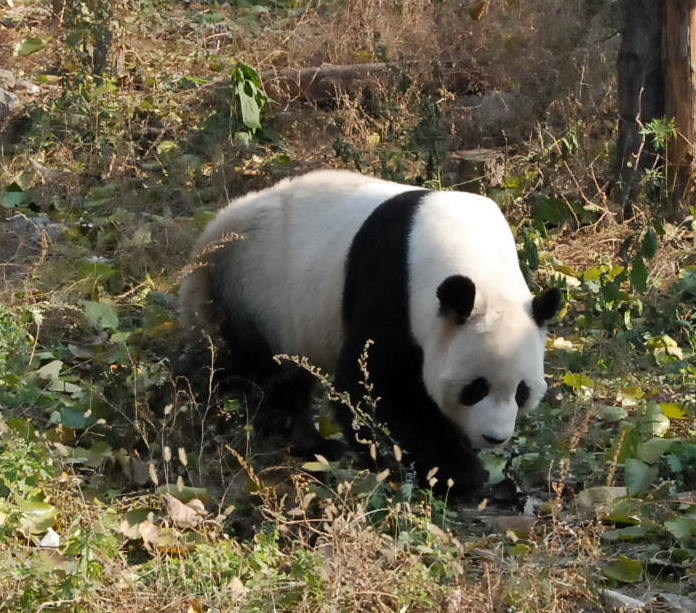

MaxViT prediction:
predicted class for image panda.jpg: 
  -> top_0 (90.04%): giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca  
  -> top_1 (0.10%): lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens  
  -> top_2 (0.08%): Arctic fox, white fox, Alopex lagopus  
  -> top_3 (0.07%): American black bear, black bear, Ursus americanus, Euarctos americanus  
  -> top_4 (0.07%): sloth bear, Melursus ursinus, Ursus ursinus  


In [36]:
#@title Inference on example image
import maxvit.models.eval_ckpt as eval_ckpt

#@markdown ### Enter a file path:
file_path = "https://upload.wikimedia.org/wikipedia/commons/f/fe/Giant_Panda_in_Beijing_Zoo_1.JPG" #@param {type:"string"}
INFER_IMAGE_SIZE = "672" #@param [224, 384, 448, 512, 672, 768, 896, 1024] {type:"string"}

# Download label map file and image
labels_map_file = 'gs://cloud-tpu-checkpoints/efficientnet/eval_data/labels_map.json'
image_file = 'panda.jpg'

!wget {file_path} -O {image_file}

image_files = [image_file]

eval_driver = eval_ckpt.MaxViTDriver(
    model_name=MODEL_NAME,
    model_input_size=TRAIN_IMAGE_SIZE,
    batch_size=1,
    image_size=int(INFER_IMAGE_SIZE),
    include_background_label=False,
    advprop_preprocessing=False,)

print(f"Input image:")
display.display(display.Image(image_file, width=INFER_IMAGE_SIZE))

print(f"MaxViT prediction:")
pred_idx, pred_prob = eval_driver.eval_example_images(
    CKPT_DIR, image_files, labels_map_file)

## 4. Inference local uploads.

Note some image formats are not supported by Tensorflow IO.

In [38]:
#@title Set model and params

MODEL_NAME = "MaxViTTiny" #@param ["MaxViTTiny", "MaxViTSmall"] {type:"string"}
TRAIN_SET = "ImageNet-1K" #@param ["ImageNet-1K"] {type:"string"}
TRAIN_IMAGE_SIZE = "224" #@param [224, 384, 512] {type:"string"}
MIXED_PRECISION = False #@param {type:"boolean"}

CKPT_DIR = CKPTS_DIRS[f'{MODEL_NAME}_{DATASET_MAP[TRAIN_SET]}_{TRAIN_IMAGE_SIZE}']

Saving red_panda.jpeg to red_panda.jpeg
Input image:


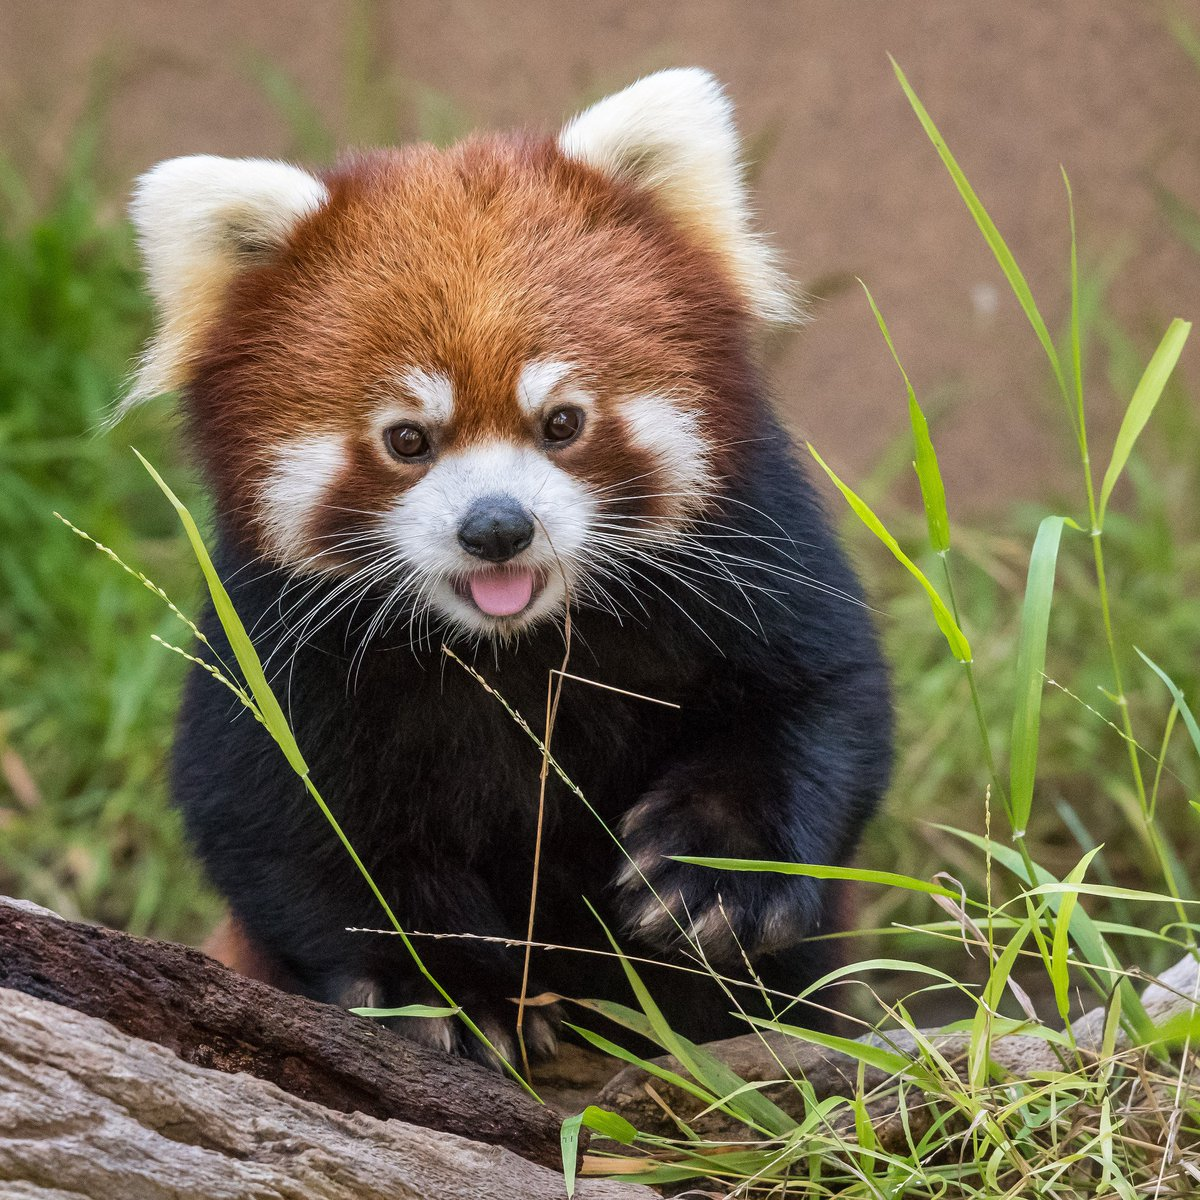

MaxViT prediction:
predicted class for image ./red_panda.jpeg: 
  -> top_0 (82.86%): lesser panda, red panda, panda, bear cat, cat bear, Ailurus fulgens  
  -> top_1 (0.23%): polecat, fitch, foulmart, foumart, Mustela putorius  
  -> top_2 (0.08%): giant panda, panda, panda bear, coon bear, Ailuropoda melanoleuca  
  -> top_3 (0.06%): mink  
  -> top_4 (0.06%): badger  


In [42]:
#@title Inference on uploaded image

from google.colab import files
uploaded = files.upload()

INFER_IMAGE_SIZE = "224" #@param [224, 384, 448, 512, 672, 768, 896, 1024] {type:"string"}


save_path = './' + list(uploaded.keys())[0]
with open(save_path, "wb") as f:
  f.write(list(uploaded.values())[0])

image_files = [save_path]

eval_driver = eval_ckpt.MaxViTDriver(
    model_name=MODEL_NAME,
    model_input_size=TRAIN_IMAGE_SIZE,
    batch_size=1,
    image_size=int(INFER_IMAGE_SIZE),
    include_background_label=False,
    advprop_preprocessing=False,)

print(f"Input image:")
display.display(display.Image(save_path, width=INFER_IMAGE_SIZE))

print(f"MaxViT prediction:")
pred_idx, pred_prob = eval_driver.eval_example_images(
    CKPT_DIR, image_files, labels_map_file)